# Data Collection, Preprocessing and EDA

In [ ]:
# !pip install fake-useragent

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import time
# from fake_useragent import UserAgent
import random
import os
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from wordcloud import WordCloud
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Scrapping the URLs Provided beforehand

In [ ]:
def clean_text(text):
    cleaned = re.sub(r'\s+', ' ', text).strip()
    cleaned = cleaned.lower()
    return cleaned

def scrape_headline(url):
    headers = {
    'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36',
    "Accept-Charset": "utf-8",
    "Accept": "*/*",
    "Accept-Language": "en-US,en;q=0.9",
    "referer": "https://www.google.com/",
    }
    # ua = UserAgent()
    # headers = {"User-Agent": ua.random}
    session = requests.Session()
    session.headers.update(headers)
    response = session.get(url)

    if response.status_code != 200:
        raise Exception(f"Failed to load page: Status code {response.status_code}")

    soup = BeautifulSoup(response.text, "html.parser")
    headline = None
    if "foxnews" in url.lower():
        headline_tag = soup.find("h1", class_="headline speakable")
    elif "nbc" in url.lower():
        headline_tag = soup.find("h1", class_="article-hero-headline__htag lh-none-print black-print")
    else:
        headline_tag = soup.find("h1")

    if not headline_tag:
        headline_tag = soup.find("h1")

    if headline_tag:
        return headline_tag.get_text()
    else:
        return None


In [ ]:
#scraping the url dataset provided
all_urls_df = pd.read_csv("/content/drive/MyDrive/CIS5190_project/url_only_data.csv")

if os.path.exists("/content/drive/MyDrive/CIS5190_project/scraped_headlines.csv"):
    print("Scraped headlines file exists")
    scraped_df = pd.read_csv("/content/drive/MyDrive/CIS5190_project/scraped_headlines.csv")
    scraped_urls = set(scraped_df["url"])
else:
    scraped_df = pd.DataFrame(columns=["title", "outlet", "label", "url"])
    scraped_urls = set()

if os.path.exists("/content/drive/MyDrive/CIS5190_project/failed_headlines.csv"):
    print("Failed headlines file exists")
    failed_df = pd.read_csv("/content/drive/MyDrive/CIS5190_project/failed_headlines.csv")
    failed_urls = set(failed_df["url"])
else:
    failed_df = pd.DataFrame(columns=["url"])
    failed_urls = set()


for index, row in all_urls_df.iterrows():
    url = row["url"]

    if url in scraped_urls or url in failed_urls:
        continue

    if "foxnews" in url.lower():
        outlet = "FoxNews"
        label = 1
    elif "nbc" in url.lower():
        outlet = "NBC"
        label = 0
    else:
        print(f"Skipping unknown outlet: {url}")
        continue

    try:
        headline = scrape_headline(url)
        if headline:
            cleaned_title = clean_text(headline)
            pd.DataFrame([{
                "title": cleaned_title,
                "outlet": outlet,
                "label": label,
                "url": url
            }]).to_csv("/content/drive/MyDrive/CIS5190_project/scraped_headlines.csv", mode="a", header=not os.path.exists("/content/drive/MyDrive/CIS5190_project/scraped_headlines.csv"), index=False)
            print(f"{index+1} Scraped: {cleaned_title}")
        else:
            raise Exception("Headline not found")

    except Exception as e:
        pd.DataFrame([{"url": url}]).to_csv("/content/drive/MyDrive/CIS5190_project/failed_headlines.csv", mode="a", header=not os.path.exists("/content/drive/MyDrive/CIS5190_project/failed_headlines.csv"), index=False)
        print(f"Failed: {url} — {e}")

    time.sleep(1)

Scraped headlines file exists
Failed headlines file exists
Failed: https://www.nbcnews.com/select/shopping/select-pet-awards-under-25-ncna1306012 — Failed to load page: Status code 500
Failed: https://www.nbcnews.com/feature/nbc-out/lil-nas-x-dolly-parton-lena-waithe-appear-virtual-glaad-n1233424 — Failed to load page: Status code 404
Failed: https://www.nbcnews.com/politics/congress/blog/electoral-college-certification-updates-n1252864/ncrd1253052#blogHeader — Headline not found
Failed: https://www.nbcnews.com/select/shopping/what-we-bought-black-friday-cyber-monday-rcna126998 — Failed to load page: Status code 500


# Preparing for scrapping 700 more NBC headlines and 500 FoxNews headlines so that final dataset consists around 2500 of each

In [ ]:
!wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!dpkg -i google-chrome-stable_current_amd64.deb
!apt-get -f install
!apt-get install -y google-chrome-stable
!google-chrome-stable --version

--2025-04-09 15:37:15--  https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
Resolving dl.google.com (dl.google.com)... 74.125.199.190, 74.125.199.93, 74.125.199.91, ...
Connecting to dl.google.com (dl.google.com)|74.125.199.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 115264952 (110M) [application/x-debian-package]
Saving to: ‘google-chrome-stable_current_amd64.deb’

google-chrome-stabl 100%[===================>] 109.92M   420MB/s    in 0.3s    

2025-04-09 15:37:15 (420 MB/s) - ‘google-chrome-stable_current_amd64.deb’ saved [115264952/115264952]

Selecting previously unselected package google-chrome-stable.
(Reading database ... 126213 files and directories currently installed.)
Preparing to unpack google-chrome-stable_current_amd64.deb ...
Unpacking google-chrome-stable (135.0.7049.84-1) ...
dpkg: dependency problems prevent configuration of google-chrome-stable:
 google-chrome-stable depends on libvulkan1; however:
  Package li

In [ ]:
!wget https://chromedriver.storage.googleapis.com/135.0.7049.42/chromedriver_linux64.zip
!unzip chromedriver_linux64.zip
!chmod +x chromedriver
!mv chromedriver /usr/bin/chromedriver

--2025-04-09 15:37:40--  https://chromedriver.storage.googleapis.com/135.0.7049.42/chromedriver_linux64.zip
Resolving chromedriver.storage.googleapis.com (chromedriver.storage.googleapis.com)... 173.194.203.207, 74.125.199.207, 74.125.20.207, ...
Connecting to chromedriver.storage.googleapis.com (chromedriver.storage.googleapis.com)|173.194.203.207|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-04-09 15:37:40 ERROR 404: Not Found.

unzip:  cannot find or open chromedriver_linux64.zip, chromedriver_linux64.zip.zip or chromedriver_linux64.zip.ZIP.
chmod: cannot access 'chromedriver': No such file or directory
mv: cannot stat 'chromedriver': No such file or directory


In [ ]:
!pip install webdriver_manager

In [ ]:
!pip install selenium
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import time
from webdriver_manager.chrome import ChromeDriverManager


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.9/492.9 kB 33.2 MB/s eta 0:00:00


In [ ]:
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=chrome_options)

url = "https://www.nbcnews.com/us-news"
driver.get(url)
wait = WebDriverWait(driver, 10)

# Scrapping 700 NBC Headlines

In [ ]:
MAX_HEADLINES = 700
headline_texts = set()

print("Scraping NBC headlines...")

while len(headline_texts) < MAX_HEADLINES:
    try:
        headlines = driver.find_elements(By.CLASS_NAME, "wide-tease-item__headline")
        for h in headlines:
            text = h.text.strip()
            if text:
                headline_texts.add(text)

        print(f"Headlines collected so far: {len(headline_texts)}")

        if len(headline_texts) >= MAX_HEADLINES:
            break

        load_more_btns = driver.find_elements(
        By.CSS_SELECTOR,
        ".animated-ghost-button.animated-ghost-button--normal.styles_button__TAu4o")
        if load_more_btns:
            driver.execute_script("arguments[0].click();", load_more_btns[0])
            time.sleep(2)
        else:
            print("No load more button found.")
            break

    except Exception as e:
        print("No more headlines or error loading more:", e)
        break

headline_texts = list(headline_texts)[:MAX_HEADLINES]

df = pd.DataFrame({
    "title": headline_texts,
    "outlet": "NBC",
    "label": 0
})

df["title"] = df["title"].str.replace(r"\s+", " ", regex=True).str.strip().str.lower()

df.to_csv("/content/drive/MyDrive/CIS5190_project/nbc_700_headlines.csv", index=False)
print(f"Final: {len(df)} NBC headlines scraped")

driver.quit()

Scraping NBC headlines...
Headlines collected so far: 11
Headlines collected so far: 31
Headlines collected so far: 51
Headlines collected so far: 71
Headlines collected so far: 91
Headlines collected so far: 111
Headlines collected so far: 131
Headlines collected so far: 150
No load more button found.
Final: 150 NBC headlines scraped


In [ ]:
df.to_csv("/content/drive/MyDrive/CIS5190_project/nbc_700_headlines.csv", index=False)


In [ ]:
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=chrome_options)

url = "https://www.nbcnews.com/tech-media"   #we manually changed multiple times to scrape from different categories
driver.get(url)
wait = WebDriverWait(driver, 10)

In [ ]:
MAX_HEADLINES = 700
headline_texts = set()

print("Scraping NBC headlines...")

while len(headline_texts) < MAX_HEADLINES:
    try:
        headlines = driver.find_elements(By.CLASS_NAME, "wide-tease-item__headline")
        for h in headlines:
            text = h.text.strip()
            if text:
                headline_texts.add(text)

        print(f"Headlines collected so far: {len(headline_texts)}")

        if len(headline_texts) >= MAX_HEADLINES:
            break

        load_more_btns = driver.find_elements(
        By.CSS_SELECTOR,
        ".animated-ghost-button.animated-ghost-button--normal.styles_button__TAu4o")
        if load_more_btns:
            driver.execute_script("arguments[0].click();", load_more_btns[0])
            time.sleep(2)
        else:
            print("No load more button found.")
            break

    except Exception as e:
        print("No more headlines or error loading more:", e)
        break

headline_texts = list(headline_texts)[:MAX_HEADLINES]

df = pd.DataFrame({
    "title": headline_texts,
    "outlet": "NBC",
    "label": 0
})

existing_path = "/content/drive/MyDrive/CIS5190_project/nbc_700_headlines.csv"
try:
    df_existing = pd.read_csv(existing_path)
    df_combined = pd.concat([df_existing, df], ignore_index=True)
    df_combined.drop_duplicates(subset=["title"], inplace=True)
except FileNotFoundError:
    df_combined = df.copy()

df_combined.to_csv(existing_path, index=False)
print(f"Updated total NBC headlines: {len(df_combined)}")

driver.quit()

Scraping NBC headlines...
Headlines collected so far: 11
Headlines collected so far: 31
Headlines collected so far: 51
Headlines collected so far: 71
Headlines collected so far: 91
Headlines collected so far: 111
Headlines collected so far: 131
Headlines collected so far: 150
No load more button found.
Updated total NBC headlines: 726


In [ ]:
#now moving to FoxNews

# Scrapping 500 FoxNews Headlines

In [ ]:
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=chrome_options)

url = "https://www.foxnews.com/"
driver.get(url)
wait = WebDriverWait(driver, 10)

In [ ]:
MAX_HEADLINES = 500
headline_texts = set()
SCROLL_PAUSE_TIME = 2
MAX_SCROLLS = 2

print("Scraping Fox News headlines...")

for scroll in range(MAX_SCROLLS):
    headlines = driver.find_elements(By.CSS_SELECTOR, "h3.title")
    for h in headlines:
        text = h.text.strip()
        if text:
            headline_texts.add(text)

    print(f"Scroll {scroll+1}: Collected {len(headline_texts)} headlines")

    if len(headline_texts) >= MAX_HEADLINES:
        break

    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(SCROLL_PAUSE_TIME)

headline_texts = list(headline_texts)[:MAX_HEADLINES]

df = pd.DataFrame({
    "title": headline_texts,
    "outlet": "FoxNews",
    "label": 1
})

df["title"] = df["title"].str.replace(r"\s+", " ", regex=True).str.strip().str.lower()

df.drop_duplicates(subset=["title"], inplace=True)

df.to_csv("/content/drive/MyDrive/CIS5190_project/fox_500_headlines.csv", index=False)
print(f"Final: {len(df)} FoxNews headlines scraped")

driver.quit()


Scraping Fox News headlines...
Scroll 1: Collected 182 headlines
Scroll 2: Collected 182 headlines
Final: 181 FoxNews headlines scraped


In [ ]:
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=chrome_options)

url = "https://www.foxnews.com/category/world/scandals"  #we manually changed multiple times to scrape from different categories
driver.get(url)
wait = WebDriverWait(driver, 10)

In [ ]:
MAX_HEADLINES = 500
headline_texts = set()
SCROLL_PAUSE_TIME = 2
MAX_SCROLLS = 2

print("Scraping Fox News section headlines...")

for scroll in range(MAX_SCROLLS):
    headlines = driver.find_elements(By.CSS_SELECTOR, "h4.title")
    for h in headlines:
        text = h.text.strip()
        if text:
            headline_texts.add(text)

    print(f"Scroll {scroll+1}: Collected {len(headline_texts)} headlines so far")

    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(SCROLL_PAUSE_TIME)

df_new = pd.DataFrame({
    "title": list(headline_texts),
    "outlet": "FoxNews",
    "label": 1
})
df_new["title"] = df_new["title"].str.replace(r"\s+", " ", regex=True).str.strip().str.lower()
df_new.drop_duplicates(subset=["title"], inplace=True)

path = "/content/drive/MyDrive/CIS5190_project/fox_500_headlines.csv"
try:
    df_existing = pd.read_csv(path)
    df_existing["title"] = df_existing["title"].str.replace(r"\s+", " ", regex=True).str.strip().str.lower()
    df_combined = pd.concat([df_existing, df_new], ignore_index=True)
    df_combined.drop_duplicates(subset=["title"], inplace=True)
except FileNotFoundError:
    df_combined = df_new.copy()

df_combined = df_combined.iloc[:MAX_HEADLINES]

df_combined.to_csv(path, index=False)
print(f"Updated FoxNews headlines saved: {len(df_combined)} rows total")

driver.quit()

Scraping Fox News section headlines...
Scroll 1: Collected 30 headlines so far
Scroll 2: Collected 30 headlines so far
Updated FoxNews headlines saved: 499 rows total


In [ ]:
df_main = pd.read_csv("/content/drive/MyDrive/CIS5190_project/scraped_headlines.csv")
df_nbc = pd.read_csv("/content/drive/MyDrive/CIS5190_project/nbc_700_headlines.csv")
df_fox = pd.read_csv("/content/drive/MyDrive/CIS5190_project/fox_500_headlines.csv")

df_nbc["url"] = "N/A"  #since didnt scrape urls of extra headlines
df_fox["url"] = "N/A"

for df in [df_main, df_nbc, df_fox]:
    df["title"] = df["title"].str.replace(r"\s+", " ", regex=True).str.strip().str.lower()

df_combined = pd.concat([df_main, df_nbc, df_fox], ignore_index=True)

df_combined.drop_duplicates(subset=["title"], inplace=True)

df_combined.to_csv("/content/drive/MyDrive/CIS5190_project/scraped_headlines.csv", index=False)
print(f"Combined dataset with {len(df_combined)} unique headlines.")

Combined dataset with 4972 unique headlines.


#Now we move to the EDA and see the distribution.

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/CIS5190_project/scraped_headlines.csv")

df["title"] = df["title"].str.strip().str.lower()

In [ ]:
print(f"Total headlines: {len(df)}")

Total headlines: 4972


In [ ]:
print("Headlines per outlet:")
print(df["outlet"].value_counts())

Headlines per outlet:
outlet
FoxNews    2497
NBC        2475
Name: count, dtype: int64


In [ ]:
print("Label distribution (Fox = 1, NBC = 0):")
print(df["label"].value_counts())

Label distribution (Fox = 1, NBC = 0):
label
1    2497
0    2475
Name: count, dtype: int64


In [ ]:
print("Sample NBC headline:")
print(df[df["outlet"] == "NBC"]["title"].sample(1).values[0])
print("Sample FoxNews headline:")
print(df[df["outlet"] == "FoxNews"]["title"].sample(1).values[0])

Sample NBC headline:
indiana man, 50, arrested on murder charges in 2017 killings of 2 teenage girls
Sample FoxNews headline:
fox nation patriot awards moves to new york with tickets now on sale


In [ ]:
df["num_words"] = df["title"].str.split().apply(len)
print("Headline length (words):")
print(df["num_words"].describe())

Headline length (words):
count    4972.000000
mean       12.929606
std         2.865852
min         1.000000
25%        11.000000
50%        13.000000
75%        15.000000
max        25.000000
Name: num_words, dtype: float64


In [ ]:
dupes = df.duplicated(subset=["title"]).sum()
print(f"Duplicate headlines (by title): {dupes}")

Duplicate headlines (by title): 0


In [ ]:
all_words = chain.from_iterable(df["title"].str.split())
word_counts = Counter(all_words)
most_common = word_counts.most_common(10)
print("Most common words:")
for word, count in most_common:
    print(f"{word}: {count}")

Most common words:
to: 1695
in: 1412
the: 1065
of: 1058
for: 841
and: 747
trump: 686
on: 677
a: 642
with: 483


# Creating Custom Stopwords

In [ ]:
# Removing Stopwords
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('punkt_tab')

def normalize_tokens(tokens):
    return [
        word.strip().lower()
        for word in tokens
        if word.isalpha()
    ]

base_stopwords = set(stopwords.words("english"))
custom_stopwords = {
    "fox", "nbc", "news", "breaking", "update", "live", "report", "video"
}
stop_words = base_stopwords.union(custom_stopwords)

keep = {"trump", "biden", "border", "court", "school", "covid"}
stop_words = stop_words - keep

tokens = df["title"].apply(word_tokenize)
tokens_norm = tokens.apply(normalize_tokens)
filtered_tokens = [
    [word for word in words if word.isalpha() and word not in stop_words]
    for words in tokens_norm
]

all_words = list(chain.from_iterable(filtered_tokens))
word_freq = Counter(all_words)

print(f"Top 20 most common words (after stopword removal):")
for word, freq in word_freq.most_common(20):
    print(f"{word}: {freq}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Top 20 most common words (after stopword removal):
trump: 852
says: 413
harris: 387
biden: 350
new: 238
israel: 210
best: 165
gaza: 149
election: 141
court: 131
house: 130
day: 130
hamas: 124
kamala: 121
first: 113
say: 111
us: 108
israeli: 107
gop: 98
war: 97


In [ ]:
with open("/content/drive/MyDrive/CIS5190_project/custom_stopwords.txt", "w") as f:
    for word in stop_words:
        f.write(word + "\n")

print(f"Stopwords saved to custom_stopwords.txt ({len(stop_words)} words)")

Stopwords saved to custom_stopwords.txt (206 words)


# Word Cloud of All Outlets Headlines

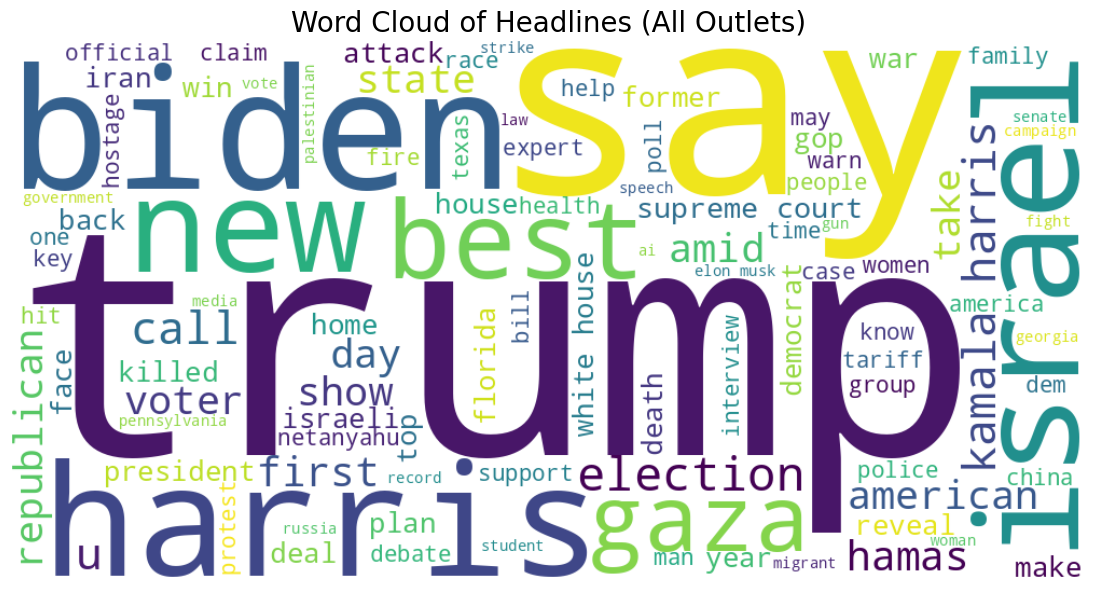

In [ ]:
all_words = list(chain.from_iterable(filtered_tokens))
# all_words = [word.strip().lower() for word in all_words if word.isalpha()]

text = " ".join(all_words)
wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color="white",
    max_words=100,
    colormap="viridis"
).generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Headlines (All Outlets)", fontsize=20)
plt.show()

In [ ]:
def get_filtered_words(df_outlet):
    tokens = df_outlet["title"].apply(word_tokenize)
    tokens_norm = tokens.apply(normalize_tokens)
    filtered_tokens = [
        [word for word in words if word.isalpha() and word not in stop_words]
        for words in tokens_norm
    ]
    all_words = list(chain.from_iterable(filtered_tokens))
    return all_words

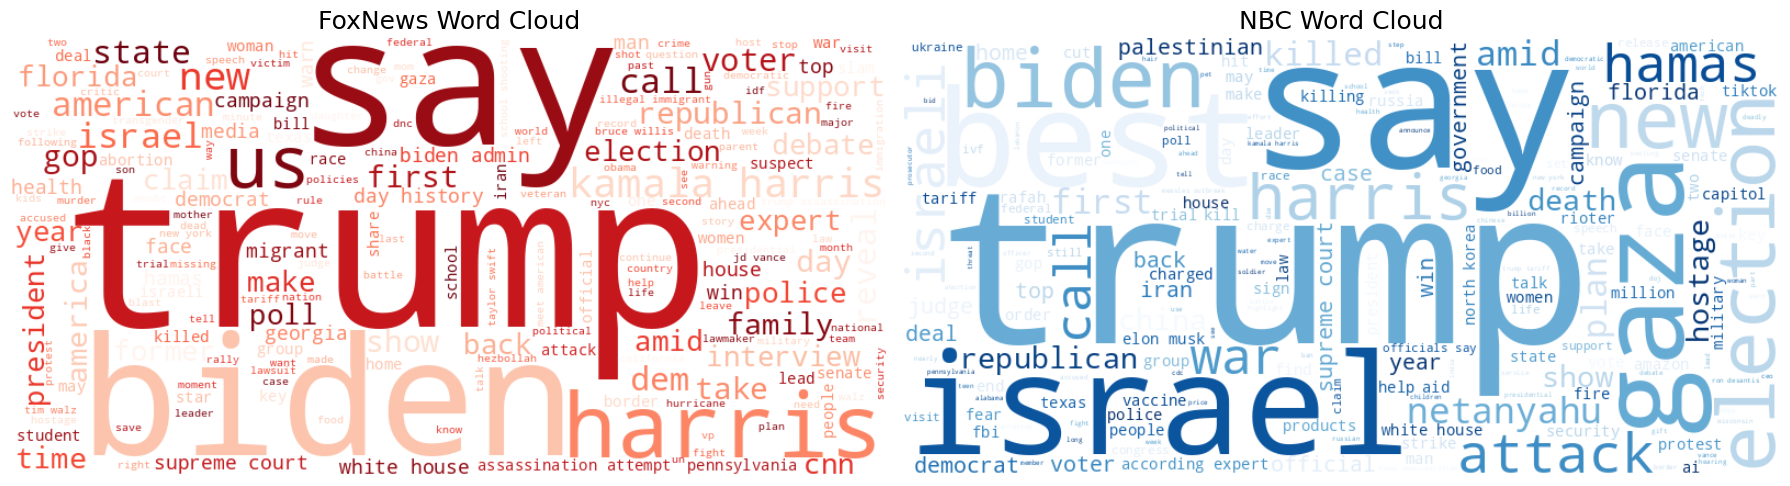

In [ ]:
df_fox = df[df["outlet"] == "FoxNews"]
df_nbc = df[df["outlet"] == "NBC"]

fox_words = get_filtered_words(df_fox)
nbc_words = get_filtered_words(df_nbc)
# fox_words = [word.strip().lower() for word in fox_words if word.isalpha()]
# nbc_words = [word.strip().lower() for word in nbc_words if word.isalpha()]

fox_text = " ".join(fox_words)
nbc_text = " ".join(nbc_words)

wc_fox = WordCloud(width=800, height=400, background_color="white", colormap="Reds").generate(fox_text)
wc_nbc = WordCloud(width=800, height=400, background_color="white", colormap="Blues").generate(nbc_text)

plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.imshow(wc_fox, interpolation="bilinear")
plt.axis("off")
plt.title("FoxNews Word Cloud", fontsize=18)

plt.subplot(1, 2, 2)
plt.imshow(wc_nbc, interpolation="bilinear")
plt.axis("off")
plt.title("NBC Word Cloud", fontsize=18)

plt.tight_layout()
plt.show()

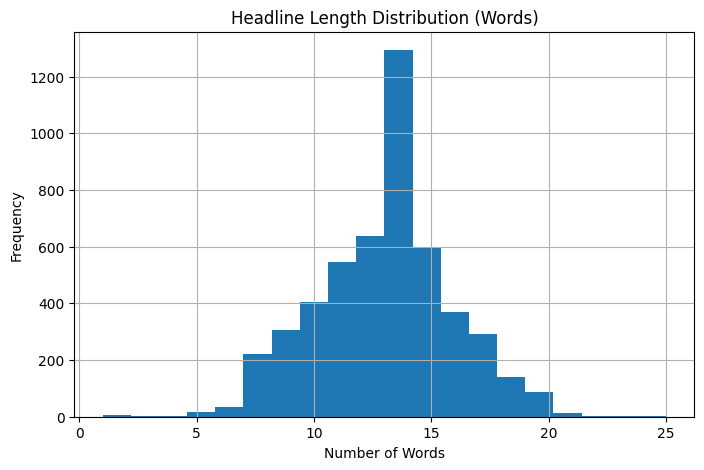

In [ ]:
plt.figure(figsize=(8,5))
df["num_words"].hist(bins=20)
plt.title("Headline Length Distribution (Words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()